# Perturbation for general consumer resource model 

In [1]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns 
import cvxpy as cvx
import time
from collections import  defaultdict
import copy

We are considering general consumer resource model 

\begin{align}
\frac{dN_i}{dt}&=N_i(\sum_\alpha C_{i\alpha}R_\alpha-m_i)\\
\frac{dR_\alpha}{dt}&=R_\alpha(K_\alpha - \sum_\beta Q_{\alpha \beta} R_\beta-\sum_j E_{j\alpha}N_j) .
\label{eq: general MCRM}
\end{align}

and test if the our correctly predict the species abundance after perturbations. To find the steady state, we could numerically solve the ODE , but we can also solve the equivalent constrained optimization problem.
\begin{align}
    \min_{\vec{R}} \sum_{\alpha\beta}\frac{1}{2}R_\alpha Q_{\alpha \beta} R_\beta-\sum_{\alpha}K_\alpha R_{\alpha}
\end{align}
with constraints
\begin{align}
    \sum_\alpha C_{i\alpha}R_\alpha-m_i&\leq0\\
    R_\alpha&>0
\end{align}


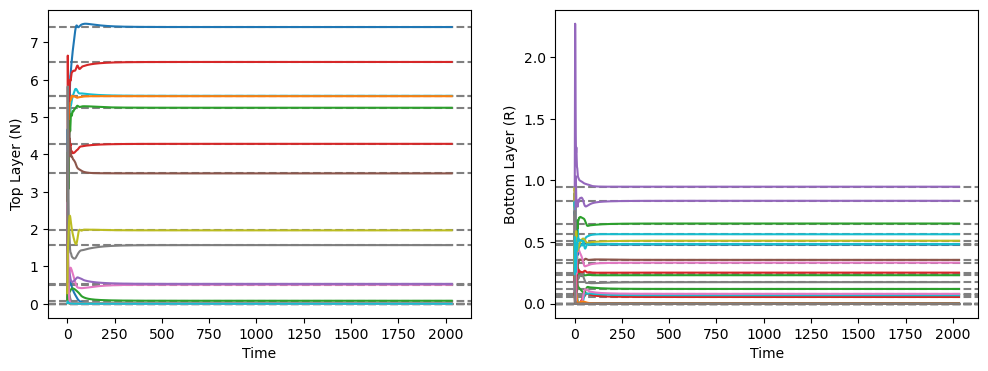

In [2]:
def generate_model_params(top_species, resources, C_mean, C_std_dev, rho, Q_mean, Q_std_dev, Q_rho, u_mean, u_std_dev, k_mean, k_std_dev):
    zero_mean_c = C_std_dev * np.random.normal(0, 1, (top_species, resources)) / np.sqrt(resources)
    C = C_mean/resources + zero_mean_c
    u = np.random.normal(u_mean, u_std_dev,top_species)
    E = generate_E(C_mean, top_species, resources, rho, zero_mean_c)
    q = np.random.normal(Q_mean,Q_std_dev, (resources, resources))
    q_a = np.random.normal(Q_mean,Q_std_dev,( resources, resources))
    Q = np.eye(resources)+Q_rho*(np.tril(q) + np.tril(q, -1).T)+ np.sqrt(1 - Q_rho) * (np.tril(q_a) -  np.tril(q_a, -1).T)  #symmetric  + antisymmetric part of Q
    k = np.random.normal(k_mean, k_std_dev,resources)
    return C, u, E, k, Q

def generate_E(E_mean, top_species, resources, rho, zero_mean_c ):
    zero_mean_d = C_std_dev * np.random.normal(0, 1, (top_species, resources)) / np.sqrt(resources)
    return E_mean/resources + rho * zero_mean_c   + np.sqrt(1 - rho**2) * zero_mean_d

def consumer_resource(t, state, top_species, C, u, k, Q,migration):
    
    X = state[:top_species]
    R = state[top_species:]

    dX = X * (np.dot(C, R) - u)+migration
    dR = R * (k - Q@R - np.dot(C.T, X))+migration

    return np.concatenate((dX, dR), axis=None)

def linear_consumer_resource(t, state, top_species, C, u, k, Q):
    
    X = state[:top_species]
    R = state[top_species:]

    dX =  (np.dot(C, R) - u)
    dR =  (k - Q@R - np.dot(C.T, X))

    return np.concatenate((dX, dR), axis=None)

def ODE_simulator(initial_state, top_species, resources, C, E, u, k, Q, migration, max_time=50000, steady_state_threshold=1e-12):
   
    ode_function = lambda t, state: consumer_resource(t, state, top_species, C, u, k, Q, migration)
    
    def check_steady_state(t, y): #Since the aim in this notebook is to find steady states, we make a event 
        derivatives = ode_function(t, y)
        #print(np.max(np.abs(derivatives)) < steady_state_threshold)
    
        return np.max(np.abs(derivatives)/y) > steady_state_threshold

    # Integrate until steady state or max_time is reached
    check_steady_state.terminal = True
    sol = solve_ivp(ode_function, t_span=(0, max_time), y0=initial_state.copy(), method='LSODA', atol=1e-10, rtol=1e-10, events=[check_steady_state])
    
    # Check if the integration reached the maximum time
    time_limit_reached = sol.t[-1] == max_time
    if time_limit_reached: print('max integration time reached')

    
    # Take surviving species
    simulator_Sbool=[(np.log(x) > np.log(migration)/2) for x in sol.y.T[-1]]
    N_simulator_Sbool=simulator_Sbool[:top_species]
    R_simulator_Sbool=simulator_Sbool[top_species:]
    #simulate again with extinct species removed, with linear dynamics, and previous steady state as initial state
    linear_ode_function = lambda t, state: linear_consumer_resource(t, state, sum(N_simulator_Sbool), C[N_simulator_Sbool,::][::,R_simulator_Sbool], u[N_simulator_Sbool], k[R_simulator_Sbool], Q[R_simulator_Sbool,::][::,R_simulator_Sbool]) #lambda t, state: linear_lotka_volterra(t, state, A[simulator_Sbool,::][::,simulator_Sbool], u[simulator_Sbool])
    
    def linear_check_steady_state(t, y): #Since the aim in this notebook is to find steady states, we make a event 
        derivatives = linear_ode_function(t, y)
        return np.max(np.abs(derivatives)) > steady_state_threshold
    linear_check_steady_state.terminal = True
    linear_sol = solve_ivp(linear_ode_function, t_span=(0, max_time), y0=sol.y.T[-1][simulator_Sbool], method='LSODA', atol=1e-12, rtol=1e-12, events=[linear_check_steady_state])
    
    #extinct species abundance are set to 0 
    full_sol=np.zeros(top_species+resources)
    full_sol[simulator_Sbool]=linear_sol.y.T[-1]
    return full_sol, linear_sol, sol

def decompose_matrix(Q):
    # Ensure A is a numpy array
    Q = np.array(Q)
    
    # Calculate the symmetric part
    Q_S = 0.5 * (Q + Q.T)
    
    # Calculate the anti-symmetric part
    Q_A = 0.5 * (Q - Q.T)
    
    return Q_S, Q_A

def find_steady_state(k, C, E, Q, u, max_iteration=100000, alpha=0.9, tol=1e-8):
    keff = k.copy()
    Q_S, Q_A = decompose_matrix(Q)
    Delta = 1
    iteration = 0
    ncyc= 0 #number of cycles
    Delta_old = 0
    
    resources=len(k)
        
    while Delta > tol and iteration < max_iteration:
        #try:
        R_opt = cvx.Variable(resources)
        constraints = [C @ R_opt <= u, R_opt >= 0]
        prob = cvx.Problem(cvx.Minimize((1/2)*cvx.quad_form(R_opt, Q_S) - keff.T @ R_opt), constraints)
        prob_output = prob.solve(solver=cvx.OSQP, eps_abs=1e-8, eps_rel=1e-8, max_iter=100000, verbose=False,polish=True)

        N_values = prob.constraints[0].dual_value
        R_values = R_opt.value
        deltak = k + (C.T - E.T) @ N_values - Q_A@ R_values - keff
        keff += alpha * deltak

        Delta_next = abs(np.max(k - Q@R_values - E.T @ N_values))

        if np.isfinite(Delta) and Delta > tol and np.abs(Delta-Delta_old) < 0.1*tol: 
                ncyc+=1 #check if the different

        Delta_old = Delta
        Delta = Delta_next
        iteration += 1
       # except:
       #     keff=keff+np.random.uniform(-1,1)*len(keff)
       #     print('optimizatino error')
                    
                    
 
        #if ncyc > 10:
        #    print('Limit cycle detected')
        #    keff=keff+np.random.uniform(-1,1)*len(keff)
        #    ncyc = 0

    if iteration == max_iteration:
        print('Delta = ',Delta,'Maximum iterations exceeded. Optimization failed. Returned inaccurate result')
        return N_values, R_values
    else:
        return N_values, R_values
    
    
def plot_simulation_results(N_values, R_values, sol, top_species, resources, yscale='linear', xscale='linear', plot_optimization=True):
    plt.figure(figsize=(12, 4))

    # Plotting top layer (N)
    plt.subplot(1, 2, 1)
    if plot_optimization:
        for value in N_values:
            plt.axhline(value, color='grey', ls='--')
    plt.plot(sol.t, sol.y[:top_species].T)
    plt.xlabel('Time')
    plt.ylabel('Top Layer (N)')
    plt.yscale(yscale)
    plt.xscale(xscale)

    # Plotting bottom layer (R)
    plt.subplot(1, 2, 2)
    if plot_optimization:
        for value in R_values:
            plt.axhline(value, color='grey', ls='--')
    plt.plot(sol.t, sol.y[top_species:].T)
    plt.xlabel('Time')
    plt.ylabel('Bottom Layer (R)')
    plt.yscale(yscale)
    plt.xscale(xscale)

    plt.show()
    
    
#Example usage
top_species = 20
resources = 30
C_mean = 5
C_std_dev = 1
rho = 1
migration = 1e-9
Q_mean = 0.5
Q_std_dev = 0.1
Q_rho = 1
u_mean, u_std_dev, k_mean, k_std_dev = 1,0.1,10,0.1

# Generate model parameters
C, u, E, k, Q = generate_model_params(top_species, resources, C_mean, C_std_dev, rho, Q_mean, Q_std_dev, Q_rho, u_mean, u_std_dev, k_mean, k_std_dev)
#print(Q)
# Define simulation parameters
max_time=50000
initial_state = np.random.rand(top_species + resources)

#Run optimization to find steady state
#R_opt = cvx.Variable(resources)
#constraints = [C @ R_opt <= u, R_opt >= 0]
#eigenvalues = np.linalg.eigvals(Q)
#print("Eigenvalues of Q_m:", eigenvalues)
#prob = cvx.Problem(cvx.Minimize((1/2)*cvx.quad_form(R_opt, Q) - k.T @ R_opt), constraints)
#prob_output = prob.solve(solver=cvx.OSQP,polish=True, eps_abs=1e-7, eps_rel=1e-7, max_iter=100000, warm_start=True)
#N_values = prob.constraints[0].dual_value
#R_values = R_opt.value
#print(N_values,R_values)
#print(Q - Q.T)
N_values, R_values=find_steady_state(k, C, E, Q, u, max_iteration=1000, alpha=0.9, tol=1e-5)
#Run simulation
_,linear_result,result = ODE_simulator( initial_state, top_species, resources, C, E, u, k,Q, migration,max_time)
plot_simulation_results(N_values, R_values, result, top_species, resources, plot_optimization=True, yscale='linear')




In [3]:
def update_ext_bool(original, shift, survival_threshold=1e-5): #bring those shifting to negatie to extinct
    original_plus_shift=original+shift
    Extbool=np.array([(x <= survival_threshold) for x in original_plus_shift])
    return Extbool

def general_perturbation_prediction(A,X,u,delta_u,knock_off,A_II,A_IS,A_SI, u_I, num_iters, momentum=0.1):
    sumX=np.sum(X)
    num_invaders=len(A_II)
    X_IList=[]
    deltaXList=[]
    predicted_XList=[]
    Ebool=knock_off
    Sbool= np.logical_not(Ebool)
    Ebool_I = np.array([False]*num_invaders)
    Sbool_I= np.logical_not(Ebool_I)
    deltaX = -sumX*Ebool.astype(int)
    X_I=np.zeros(num_invaders)
    for i in range(num_iters):
        Sbool= np.logical_not(Ebool)
        Sbool_I= np.logical_not(Ebool_I) 
        X_S = X[Sbool]
        X_E = X[Ebool]
        A_SS_inv=np.linalg.inv(A[Sbool,::][::,Sbool])
        A_SE=A[Sbool,::][::,Ebool]
        delta_u_S=delta_u[Sbool]
        #num_invaders=sum(Sbool_I)
        if num_invaders>0:
            A_IS_s=A_IS[Sbool_I,::][::,Sbool]
            A_SI_s=A_SI[Sbool,::][::,Sbool_I]
            A_II_s=A_II[Sbool_I,::][::,Sbool_I]  
            u_I_s=u_I[Sbool_I]
            X_I_s=X_I[Sbool_I]
            
            M_inv=np.linalg.inv(A_II_s-A_IS_s@A_SS_inv@A_SI_s)
            X_I_s=M_inv@(u_I_s-A_IS_s@X_S-A_IS_s@A_SS_inv@(delta_u_S+A_SE@X_E))
           
            #removing invaders if it goes negative or explode to infinity
            for j in range(len(X_I_s)):
                if X_I_s[j]<0 or X_I_s[j]>sumX:
                    X_I_s[j]=0
                    Ebool_I[j]=True
                    
            X_I[Sbool_I]=X_I_s
            
            deltaX_new=A_SS_inv@(delta_u_S-A_SI_s@X_I_s+A_SE@X_E)
        
        else: 
            deltaX_new=A_SS_inv@(delta_u_S+A_SE@X_E)
            #X_I=[]
        
        #if np.sum((deltaX_new-deltaX[Sbool])**2)<accuracy: #check convergence, break if converged
        #    break
        if i==0: #first iteration
            deltaX[Sbool]=deltaX_new
        else:   
            # instead of update to delta_new directly, we do momentum updates to improve convergence 
            deltaX[Sbool]=copy.deepcopy(deltaX[Sbool])*momentum+(1-momentum)*deltaX_new
            
        XExtgrowth=u[Ebool]-A[Ebool,::][::,Sbool]@(X_S+deltaX[Sbool])
        if num_invaders>0: X_IExtgrowth=u_I[Ebool_I]-A_IS[Ebool_I,::][::,Sbool]@(X_S+deltaX[Sbool])
        
        oldEbool=copy.deepcopy(Ebool)
        #print(oldEbool)
        #bringing back the species with positive growth rates with chance except knock-offs
        Ebool[Ebool]=[(x < 1e-8) for x in XExtgrowth] 
        Ebool[knock_off]=knock_off[knock_off]
        if num_invaders>0: Ebool_I[Ebool_I]=[(x < 0) for x in X_IExtgrowth] 
        
        #removing species with negative abundance after proposed shift
        Ebool[Sbool] = update_ext_bool(X[Sbool], deltaX[Sbool])
                
        #save result
        X_IList.append(X_I)
        deltaXList.append(deltaX)
        
        predicted_X=np.concatenate((np.clip(deltaX+X, 0, None),X_I))
        predicted_XList.append(predicted_X)
        
        #check convergence
        if np.all(oldEbool==Ebool):
            break
    return X_IList, deltaXList,  predicted_XList

def prediction_given_Sbool(A,X,u,delta_u,A_II,A_IS,A_SI, u_I,Sbool,Sbool_I,knock_off): 
    
    Ebool_I= np.logical_not(Sbool_I)
    Ebool= np.logical_not(Sbool)
    not_knock_off=np.logical_not(knock_off)
    Ebool[knock_off]=True
    X_I=np.zeros(num_invaders)
    deltaX=np.zeros(len(A))
    
    X_S = X[Sbool]
    X_E = X[Ebool]
    A_SS_inv=np.linalg.inv(A[Sbool,::][::,Sbool])
    A_SE=A[Sbool,::][::,Ebool]
    delta_u_S=delta_u[Sbool]
    A_IS_s=A_IS[Sbool_I,::][::,Sbool]
    A_SI_s=A_SI[Sbool,::][::,Sbool_I]
    A_II_s=A_II[Sbool_I,::][::,Sbool_I]  
    u_I_s=u_I[Sbool_I]
    X_I_s=X_I[Sbool_I]
    M_inv=np.linalg.inv(A_II_s-A_IS_s@A_SS_inv@A_SI_s)
    X_I_s=M_inv@(u_I_s-A_IS_s@X_S-A_IS_s@A_SS_inv@(delta_u_S+A_SE@X_E))
    deltaXs=A_SS_inv@(delta_u_S-A_SI_s@X_I_s+A_SE@X_E)
    
    deltaX[Sbool]=deltaXs
    X_I[Sbool_I]=X_I_s
    newX=deltaX+X
    newX[Ebool]= 0
    predicted_X=np.concatenate((newX,X_I))
    return predicted_X


In [29]:
def create_block_matrix(A, B, C, D):   

    # Create the block matrix using np.block
    block_matrix = np.block([
        [A, B],
        [C, D]
    ])
    
    return block_matrix

def make_A(C,E,Q):
    zeros=np.zeros((len(C),len(C)))
    # Create the block matrix using create_block_matrix
    A = create_block_matrix(zeros, C,E.T, Q)
    return A

def make_X(N,R):
    X=np.concatenate((N,R))
    return X

def make_u(m,k):
    u=np.concatenate((-m,k))
    return u

#make_A(C,E,np.eye((len(C.T))))
def set_random_true(boolean_array, num_to_set_true): # for knockoffs
    # Get indices of False values in the array
    false_indices = np.where(boolean_array == False)[0]
    
    # If there are fewer False values than num_to_set_true, raise an error
    if len(false_indices) < num_to_set_true:
        raise ValueError("Number of False values is less than num_to_set_true.")
        
    # Randomly choose indices to set to True
    indices_to_set_true = np.random.choice(false_indices, num_to_set_true, replace=False)
    
    # Set the chosen indices to True
    boolean_array[indices_to_set_true] = True
    
    return boolean_array
def predict_CRM_with_LV(Cs,Es,Qs,oldNs,oldRs,ms,k,E_I, C_I, m_I, delta_m,knock_off, num_iters=50, momentum=0.1):
    resources=len(k)
    num_invaders=len(m_I)
    num_native=len(Cs)
    As=make_A(Cs,Es,Qs)
    oldXs=make_X(oldNs,oldRs)
    us=make_u(ms,k)
    delta_u=make_u(delta_m,np.zeros(len(Qs)))
    A_II=np.zeros((num_invaders,num_invaders))
    A_IS=np.block([[np.zeros((num_invaders,num_native)),C_I]])
    A_SI=np.block([[np.zeros((num_native,num_invaders))],[E_I.T]])
    u_I=m_I
    full_knock_off=np.concatenate((knock_off,np.array([False]*len(Qs))))
    _, _,  predicted_XList=general_perturbation_prediction(As,oldXs,us,delta_u,full_knock_off,A_II,A_IS,A_SI, u_I, num_iters=50, momentum=0.1)
    perturbation_prediction = np.array(predicted_XList)[-1]   
    native_N_prediction=perturbation_prediction[:num_native]
    native_R_prediction=perturbation_prediction[num_native:num_native+len(Qs)]
    invader_N_prediction=perturbation_prediction[num_native+len(Qs):]
    rearranged_perturbation_prediction=np.concatenate((native_N_prediction,invader_N_prediction,native_R_prediction))

    return np.concatenate((native_N_prediction,invader_N_prediction)), native_R_prediction

def info_predict_CRM_with_LV(Cs,Es,Qs,oldNs,oldRs,ms,k,E_I, C_I, m_I,knock_off,N_simulator_Sbool,R_simulator_Sbool):
    As=make_A(Cs,Es,Qs)
    oldXs=make_X(oldNs,oldRs)
    us=make_u(ms,k)
    delta_u=make_u(delta_m,np.zeros(len(Qs)))
    A_II=np.zeros((num_invaders,num_invaders))
    A_IS=np.block([[np.zeros((num_invaders,num_native)),C_I]])
    A_SI=np.block([[np.zeros((num_native,num_invaders))],[E_I.T]])
    u_I=m_I
    full_knock_off=np.concatenate((knock_off,np.array([False]*len(Qs))))
    full_simulator_Sbool=np.concatenate((N_simulator_Sbool,R_simulator_Sbool))
    Sbool_I=N_simulator_Sbool[len(Cs):]
    Sbool=np.concatenate((N_simulator_Sbool[:len(Cs)],R_simulator_Sbool))
    perturbation_prediction=prediction_given_Sbool(As,oldXs,us,delta_u,A_II,A_IS,A_SI, u_I,Sbool,Sbool_I,full_knock_off)
    return perturbation_prediction

def consumer_invasion_and_knock_off(C, E, Q, C_I, E_I, m, m_I, knock_off):
    not_knock_off= np.logical_not(knock_off)
    C_new=np.concatenate((C[not_knock_off],C_I))
    E_new=np.concatenate((E[not_knock_off],E_I))
    m_new = np.concatenate((m[not_knock_off], m_I))
    return C_new, E_new, m_new


In [30]:
def deduce_extinction_threshold_log(data):
    """
    Deduce a threshold for extinction in abundance data using the log distribution and the middle of the gap.
    
    Parameters:
    data (array-like): Array of abundance data.
    
    Returns:
    float: The deduced extinction threshold.
    """
    data = np.array(data)
    data_nonzero = data[data > 0]  # Remove zero or negative values to avoid log issues
    log_data = np.log(data_nonzero)
    
    # Sort the log-transformed data
    sorted_log_data = np.sort(log_data)
    
    # Find the middle of the largest gap in the log-transformed data
    log_gaps = np.diff(sorted_log_data)
    max_gap_index = np.argmax(log_gaps)
    
    middle_of_gap = (sorted_log_data[max_gap_index] + sorted_log_data[max_gap_index + 1]) / 2
    
    # Convert back from log scale to original scale
    threshold = np.exp(middle_of_gap)
    
    return threshold


In [39]:
# Parameters

num_systems = 1
num_knock_offs = 0 # Number of knock-offs
num_invaders=1 # Number of invaders

top_species = 60
resources = 30
C_mean = 1
C_std_dev = 0.5
rho = 1
Q_mean = 0
Q_std_dev = 0
Q_rho = 0
u_mean, u_std_dev = 1,0.1
k_mean, k_std_dev =2,0.1

deltam_mean = 0
deltam_std_dev = 0

simulationN_after = []
simulationR_after = []

predictionNs = []
predictionRs = []

info_predicted_Ns = []
info_predicted_Rs = []

invader_ODE_steady_states=[]
invader_predictions=[]

sim_Nbools=[]
sim_Rbools=[]

prediction_Nbool=[]
prediction_Rbool=[]

for system_idx in range(num_systems):
    # Generate model parameters for each system
    C, m, E, k, Q = generate_model_params(top_species, resources, C_mean, C_std_dev, rho, Q_mean, Q_std_dev, Q_rho, u_mean, u_std_dev, k_mean, k_std_dev)
    max_time=20000
    initial_state = np.ones(top_species+resources)

    # Simulate the initial system
    oldN, oldR=find_steady_state(k, C, E, Q, m, max_iteration=1000, alpha=0.1, tol=1e-5)
    #print(oldN, oldR)
    #Deduce a threshold to determine extinction
    #N_threshold = deduce_extinction_threshold_log(oldN)
    #R_threshold = deduce_extinction_threshold_log(oldR)
    N_threshold = 1e-3
    R_threshold= 1e-9
   # Take the initial surviving system 
    N_Sbool=[(x > N_threshold) for x in oldN] 
    R_Sbool=[(x > R_threshold) for x in oldR] 
    
    num_native=sum(N_Sbool)
    num_sur_resources=sum(R_Sbool)
    
    Cs, Es, ms, oldNs, oldRs, ks ,Qs = C[N_Sbool,::][::,R_Sbool],E[N_Sbool,::][::,R_Sbool],m[N_Sbool],oldN[N_Sbool], oldR[R_Sbool],k[R_Sbool],Q[R_Sbool,::][::,R_Sbool]
    
    #sample knockoff
    
    knock_off=np.array([False]*num_native,dtype=bool)
    knock_off=set_random_true(knock_off, num_knock_offs)
    not_knock_off=np.concatenate((np.logical_not(knock_off),np.array([True]*num_invaders,dtype=bool)))
    
    #sample invaders until invasion fitness is positive
    continue_sampling=True
    while continue_sampling:
        
        C_I, m_I, E_I, _, _ = generate_model_params(num_invaders, num_sur_resources, C_mean, C_std_dev, rho, Q_mean, Q_std_dev, Q_rho, u_mean, u_std_dev, k_mean, k_std_dev)
        if C_I@oldRs-m_I>0:continue_sampling=False
        
    #Sample environmental perturbation
    delta_m=np.random.normal(deltam_mean, deltam_std_dev, num_native)
    
    # Add invaders and remove knockoffs
    new_top_species=num_native+num_invaders-num_knock_offs
    new_initial_state=np.random.rand(new_top_species+num_sur_resources)
    
    # Simulate the new system with the perturbation
    C_new, E_new, m_new = consumer_invasion_and_knock_off(Cs, Es, Qs, C_I, E_I, ms+delta_m, m_I, knock_off)
    newN=np.zeros(new_top_species)
    newN[not_knock_off], newR = find_steady_state(ks, C_new, E_new, Qs, m_new, max_iteration=1000, alpha=0.1, tol=1e-5)
    
    N_simulator_Sbool=[(x > N_threshold) for x in newN]
    R_simulator_Sbool=[(x > R_threshold) for x in newR]
    
    simulationN_after.append(newN)
    simulationR_after.append(newR)
    
    # Compute perturbation prediction given what survives
    #num_original=len(Cs)
    #info_predicted_X=info_predict_CRM_with_LV(Cs,Es,Qs,oldNs,oldRs,ms,ks,E_I, C_I, m_I,knock_off,N_simulator_Sbool,R_simulator_Sbool)
    
    #native_N_info_prediction=info_predicted_X[:num_native]
    #native_R_info_prediction=info_predicted_X[num_native:num_native+resources]
    #invader_N_info_prediction=info_predicted_X[num_native+resources:]
    
    #info_predicted_Ns.append(np.concatenate((native_N_info_prediction,invader_N_info_prediction)))
    #info_predicted_Rs.append(native_R_info_prediction)
    
    # Compute perturbation prediction with ierative
    N_prediction,R_prediction=predict_CRM_with_LV(Cs,Es,Qs,oldNs,oldRs,ms,ks,E_I, C_I, m_I, delta_m,knock_off, num_iters=50, momentum=0.1)

    predictionNs.append(N_prediction)
    predictionRs.append(R_prediction)
    
    invader_ODE_steady_states.append(newN[-1])
    invader_predictions.append(N_prediction[-1])
    
    sim_Nbools.append(N_simulator_Sbool)
    sim_Rbools.append(R_simulator_Sbool)
    
    prediction_Nbool.append(N_prediction> N_threshold)
    prediction_Rbool.append(R_prediction> R_threshold)
    
    
    


In [76]:
from multiprocess import Pool

assumptions = {
    "num_knock_offs": 0,
    "num_invaders": 1,
    "top_species": 60,
    "resources": 30,
    "C_mean": 1,
    "C_std_dev": 0.5,
    "rho": 1,
    "Q_mean": 0.1,
    "Q_std_dev": 0.1,
    "Q_rho": 0.1,
    "u_mean": 1,
    "u_std_dev": 0.1,
    "k_mean": 2,
    "k_std_dev": 0.1,
    "deltam_mean": 0,
    "deltam_std_dev": 0
}

def simulate_single_system(assumptions):
    np.random.seed(None)
    # Extract parameters from the assumptions dictionary
    top_species = assumptions['top_species']
    resources = assumptions['resources']
    C_mean = assumptions['C_mean']
    C_std_dev = assumptions['C_std_dev']
    rho = assumptions['rho']
    Q_mean = assumptions['Q_mean']
    Q_std_dev = assumptions['Q_std_dev']
    Q_rho = assumptions['Q_rho']
    u_mean = assumptions['u_mean']
    u_std_dev = assumptions['u_std_dev']
    k_mean = assumptions['k_mean']
    k_std_dev = assumptions['k_std_dev']
    num_knock_offs = assumptions['num_knock_offs']
    num_invaders = assumptions['num_invaders']
    deltam_mean = assumptions['deltam_mean']
    deltam_std_dev = assumptions['deltam_std_dev']
    N_threshold = assumptions.get('N_threshold', 1e-3)
    R_threshold = assumptions.get('R_threshold', 1e-9)

    # Generate model parameters for each system
    C, m, E, k, Q = generate_model_params(top_species, resources, C_mean, C_std_dev, rho,
                                          Q_mean, Q_std_dev, Q_rho
                                          u_mean, u_std_dev, k_mean, k_std_dev)
    
    
    # Simulate the initial system
    oldN, oldR = find_steady_state(k, C, E, Q, m, max_iteration=1000, alpha=0.1, tol=1e-7)
    
    # Determine extinction thresholds
    N_Sbool = [(x > N_threshold) for x in oldN]
    R_Sbool = [(x > R_threshold) for x in oldR]
    #print(oldN,flush=True)
    num_native = sum(N_Sbool)
    num_sur_resources = sum(R_Sbool)

    Cs = C[N_Sbool][:, R_Sbool]
    Es = E[N_Sbool][:, R_Sbool]
    ms = m[N_Sbool]
    oldNs = oldN[N_Sbool]
    oldRs = oldR[R_Sbool]
    ks = k[R_Sbool]
    Qs = Q[R_Sbool][:, R_Sbool]

    # Sample knockoff
    knock_off = np.array([False] * num_native)
    knock_off = set_random_true(knock_off, num_knock_offs)
    not_knock_off = np.concatenate((np.logical_not(knock_off), np.array([True] * num_invaders)))

    # Sample invaders until invasion fitness is positive
    continue_sampling = True
    while continue_sampling:
        C_I, m_I, E_I, _, _ = generate_model_params(num_invaders,
                                                    num_sur_resources,
                                                    C_mean,
                                                    C_std_dev,
                                                    rho,
                                                    Q_mean,
                                                    Q_std_dev,
                                                    Q_rho,
                                                    u_mean,
                                                    u_std_dev,
                                                    k_mean,
                                                    k_std_dev)
        if C_I @ oldRs - m_I > 0:
            continue_sampling = False

    # Sample environmental perturbation
    delta_m = np.random.normal(deltam_mean, deltam_std_dev, num_native)

    # Add invaders and remove knockoffs
    new_top_species = num_native + num_invaders - num_knock_offs
    new_initial_state = np.random.rand(new_top_species + num_sur_resources)

    # Simulate the new system with the perturbation
    C_new, E_new, m_new = consumer_invasion_and_knock_off(Cs,
                                                          Es,
                                                          Qs,
                                                          C_I,
                                                          E_I,
                                                          ms + delta_m,
                                                          m_I,
                                                          knock_off)
    
    newN = np.zeros(new_top_species)
    
    newN[not_knock_off], newR = find_steady_state(ks,
                                                      C_new,
                                                      E_new,
                                                      Qs,
                                                      m_new,
                                                      max_iteration=1000,
                                                      alpha=0.1,
                                                      tol=1e-7)
    
    N_simulator_Sbool = [(x > N_threshold) for x in newN]
    R_simulator_Sbool = [(x > R_threshold) for x in newR]
    
    # Compute perturbation prediction with iterative method
    N_prediction,R_prediction=predict_CRM_with_LV(Cs,
                                                  Es,
                                                  Qs,
                                                  oldNs,
                                                  oldRs,
                                                  ms,
                                                  ks,
                                                  E_I,
                                                  C_I,
                                                  m_I,
                                                  delta_m,
                                                  knock_off,
                                                  num_iters=50,
                                                  momentum=0.1)
    
    return {"simulationN_after": newN,
            "simulationR_after": newR,
            "predictionNs": N_prediction,
            "predictionRs": R_prediction,
            "invader_ODE_steady_states": newN[-1],
            "invader_predictions": N_prediction[-1],
            "sim_Nbools": N_simulator_Sbool,
            "sim_Rbools": R_simulator_Sbool,
            "prediction_Nbool": N_prediction > N_threshold,
            "prediction_Rbool": R_prediction > R_threshold
    }

num_systems = 640

if __name__ == '__main__':
     with Pool() as pool:
         temp_results=[pool.apply_async(simulate_single_system,args=(assumptions,))
                       for _ in range(num_systems)]
         
         output_data=[res.get() for res in temp_results]


In [100]:
def unpack_results(results):
    if not results:
        return {}
    # Extract all keys from the first result
    keys = results[0].keys()
    # Create a dictionary with each key mapped to a list of corresponding values
    return {key: [result[key] for result in results] for key in keys}
MCRM_unpacked_data = unpack_results(output_data)


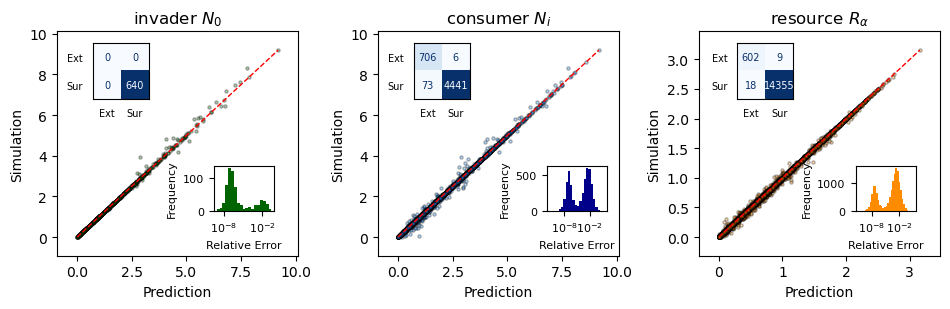

In [107]:
 from sklearn.metrics import confusion_matrix, r2_score, ConfusionMatrixDisplay
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize
# Function to format ticks as 10^(log(error))
def log_formatter(x, pos):
    return f'$10^{{{int(x)}}}$'


def plot_confusion_matrix(true_labels, predicted_labels, labels=('Ext', 'Sur'), font_size=7, ax=None):
    cm = confusion_matrix(true_labels, predicted_labels, labels = [False,True])
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    display.plot(cmap='Blues', ax=ax, colorbar=False)
    
    # Set custom tick labels
    ax.set_xticklabels(labels, fontsize=font_size)
    ax.set_yticklabels(labels, fontsize=font_size)
    
    # Remove or customize axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Customize grid appearance
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="both", bottom=False, left=False)

    # Change font size of text annotations
    for text in display.text_.ravel():
        text.set_fontsize(font_size)

    if ax is None:
        plt.tight_layout()
        plt.show()


# Combine scatter plots and histograms
figure_width = 3.2
fig, ax = plt.subplots(1, 3, figsize=(figure_width * 3, figure_width * 1))

# Filter data for positive predictions
sim_Nbools_concatenated = np.concatenate(MCRM_unpacked_data['sim_Nbools'])
prediction_Nbool_concatenated = np.concatenate(MCRM_unpacked_data['prediction_Nbool'])
intersection = [a and b for a, b in zip(sim_Nbools_concatenated, prediction_Nbool_concatenated)]
positive_indices_N = np.array(intersection) > 0

# Filter data for positive predictions
sim_Rbools_concatenated = np.concatenate(MCRM_unpacked_data['sim_Rbools'])
prediction_Rbool_concatenated = np.concatenate(MCRM_unpacked_data['prediction_Rbool'])
intersection = [a and b for a, b in zip(sim_Rbools_concatenated, prediction_Rbool_concatenated)]
positive_indices_R = np.array(intersection) > 0

filtered_simulationR_after = np.concatenate(MCRM_unpacked_data['simulationR_after'])[positive_indices_R]
filtered_predictionRs = np.concatenate(MCRM_unpacked_data['predictionRs'])[positive_indices_R]


filtered_simulationN_after = np.concatenate(MCRM_unpacked_data['simulationN_after'])[positive_indices_N]
filtered_predictionNs = np.concatenate(MCRM_unpacked_data['predictionNs'])[positive_indices_N]

# Calculate R^2 values
#r2_n = r2_score(filtered_simulationN_after, filtered_predictionNs)
#r2_r = r2_score(filtered_simulationR_after, filtered_predictionRs)

# Scatter plot for N (reversed axes)
maxN = np.max(np.concatenate(MCRM_unpacked_data['predictionNs']))
scatter_n = ax[1].scatter(filtered_predictionNs, filtered_simulationN_after, s=5, alpha=0.3, c='dodgerblue', edgecolors='black')
ax[1].plot([0, maxN], [0, maxN], color='r', linestyle='dashed', linewidth=1)
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Simulation')
ax[1].set_xlim(-maxN * 0.1, 1.1 * maxN)
ax[1].set_ylim(-maxN * 0.1, 1.1 * maxN)
ax[1].set_title(f'consumer $N_i$')

# Add confusion matrix inset for N
inset_ax_n = ax[1].inset_axes([0.14, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_Nbools_concatenated, prediction_Nbool_concatenated, ax=inset_ax_n)


# Histogram for relative error of N
ax_hist1 = ax[1].inset_axes([0.7, 0.2, 0.25, 0.2])
ax_hist1.hist(np.log10(np.abs(filtered_simulationN_after - filtered_predictionNs) / filtered_simulationN_after), bins='auto', color='darkblue', edgecolor='none')
ax_hist1.set_xlabel('Relative Error', fontsize=8)
ax_hist1.set_ylabel('Frequency', fontsize=8)
ax_hist1.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist1.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist1.set_xticks([-8, -2])  # Replace with your desired tick positions
ax_hist1.set_xticklabels(['$10^{-8}$', '$10^{-2}$'])  # Replace with your desired tick labels


# Scatter plot for R 
maxR = np.max(np.concatenate(MCRM_unpacked_data['predictionRs']))
scatter_r = ax[2].scatter(filtered_predictionRs, filtered_simulationR_after, s=5, alpha=0.3, c='darkorange', edgecolors='black')
ax[2].plot([0, maxR], [0, maxR], color='r', linestyle='dashed', linewidth=1)
ax[2].set_xlabel('Prediction')
ax[2].set_ylabel('Simulation')
ax[2].set_xlim(-maxR * 0.1, 1.1 * maxR)
ax[2].set_ylim(-maxR * 0.1, 1.1 * maxR)
ax[2].set_title(f'resource $R_α$')

# Add confusion matrix inset for R
inset_ax_r = ax[2].inset_axes([0.15, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_Rbools_concatenated, prediction_Rbool_concatenated, ax=inset_ax_r)

# Histogram for relative error of R
ax_hist2 = ax[2].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist2.hist(np.log10(np.abs(filtered_simulationR_after - filtered_predictionRs) / filtered_simulationR_after), bins='auto', color='darkorange', edgecolor='none')
ax_hist2.set_xlabel('Relative Error', fontsize=8)
ax_hist2.set_ylabel('Frequency', fontsize=8)
ax_hist2.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist2.tick_params(axis='both', which='major', labelsize=8)
# Set custom x-ticks
ax_hist2.set_xticks([-8, -2])  # Replace with your desired tick positions
ax_hist2.set_xticklabels(['$10^{-8}$', '$10^{-2}$'])  # Replace with your desired tick labels


simulation_invader = np.array([x[-1] for x in MCRM_unpacked_data['simulationN_after']])
prediction_invader = np.array([x[-1] for x in MCRM_unpacked_data['predictionNs']])

# Convert continuous data to binary/categorical if necessary
#threshold_invader = 0.01 # Define a threshold value if needed
#sim_invader_bool = simulation_invader > threshold_invader
#pred_invader_bool = prediction_invader > threshold_invader
sim_Nbools_concatenated = np.concatenate(sim_Nbools)
prediction_Nbool_concatenated = np.concatenate(prediction_Nbool)

sim_invader_bool =  np.array([x[-1] for x in MCRM_unpacked_data['sim_Nbools']])
pred_invader_bool =  np.array([x[-1] for x in MCRM_unpacked_data['prediction_Nbool']])

intersection = [a and b for a, b in zip(sim_invader_bool, pred_invader_bool)]
N0_positive_indices = np.array(intersection) > 0
#print(sim_invader_bool,pred_invader_bool)

# Filter N_0 data for positive predictions
filtered_simulation_invader = simulation_invader[N0_positive_indices]
filtered_prediction_invader = prediction_invader[N0_positive_indices]
#r2_n0 = r2_score(filtered_simulation_invader, filtered_prediction_invader)


# Scatter plot for N_0 
maxN0 = np.max(filtered_prediction_invader)
scatter_n0 = ax[0].scatter(filtered_prediction_invader, filtered_simulation_invader, s=5, alpha=0.3, c='darkgreen', edgecolors='black')
ax[0].plot([0, maxN0], [0, maxN0], color='r', linestyle='dashed', linewidth=1)
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Simulation')
ax[0].set_xlim(-maxN0 * 0.1, 1.1 * maxN0)
ax[0].set_ylim(-maxN0 * 0.1, 1.1 * maxN0)
ax[0].set_title(f'invader $N_0$')

# Add confusion matrix inset for N_0
inset_ax_n0 = ax[0].inset_axes([0.14, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_invader_bool, pred_invader_bool, ax=inset_ax_n0)

# Histogram for relative error of N_0
ax_hist0 = ax[0].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist0.hist(np.log10(np.abs(filtered_simulation_invader - filtered_prediction_invader) / filtered_simulation_invader), bins='auto', color='darkgreen', edgecolor='none')
ax_hist0.set_xlabel('Relative Error', fontsize=8)
ax_hist0.set_ylabel('Frequency', fontsize=8)
ax_hist0.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist0.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist0.set_xticks([-8, -2])  # Replace with your desired tick positions
ax_hist0.set_xticklabels(['$10^{-8}$', '$10^{-2}$'])  # Replace with your desired tick labels

plt.tight_layout()
fig.savefig("single_MCRM_work.svg", format="svg")

plt.show()